## Before we start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.


In [1]:
!nvidia-smi

Wed Mar  6 21:25:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


In [4]:
# Git clone method (for development)

%cd {HOME}
!git clone github.com/ultralytics/ultralytics
%cd {HOME}/ultralytics
!pip install -e .

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="owIgNp5Dc5t9X9zSnNNq")
project = rf.workspace("indianvehicles").project("vehicle_detection_2")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [7]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=100 imgsz=800 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 235MB/s]
New https://pypi.org/project/ultralytics/8.1.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/vehicle_detection_2-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_bu

In [8]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      val_batch0_labels.jpg
confusion_matrix.png				    R_curve.png       val_batch0_pred.jpg
events.out.tfevents.1709760380.8840d1824bd0.1519.0  results.csv       val_batch1_labels.jpg
F1_curve.png					    results.png       val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg  weights
labels.jpg					    train_batch1.jpg


/content


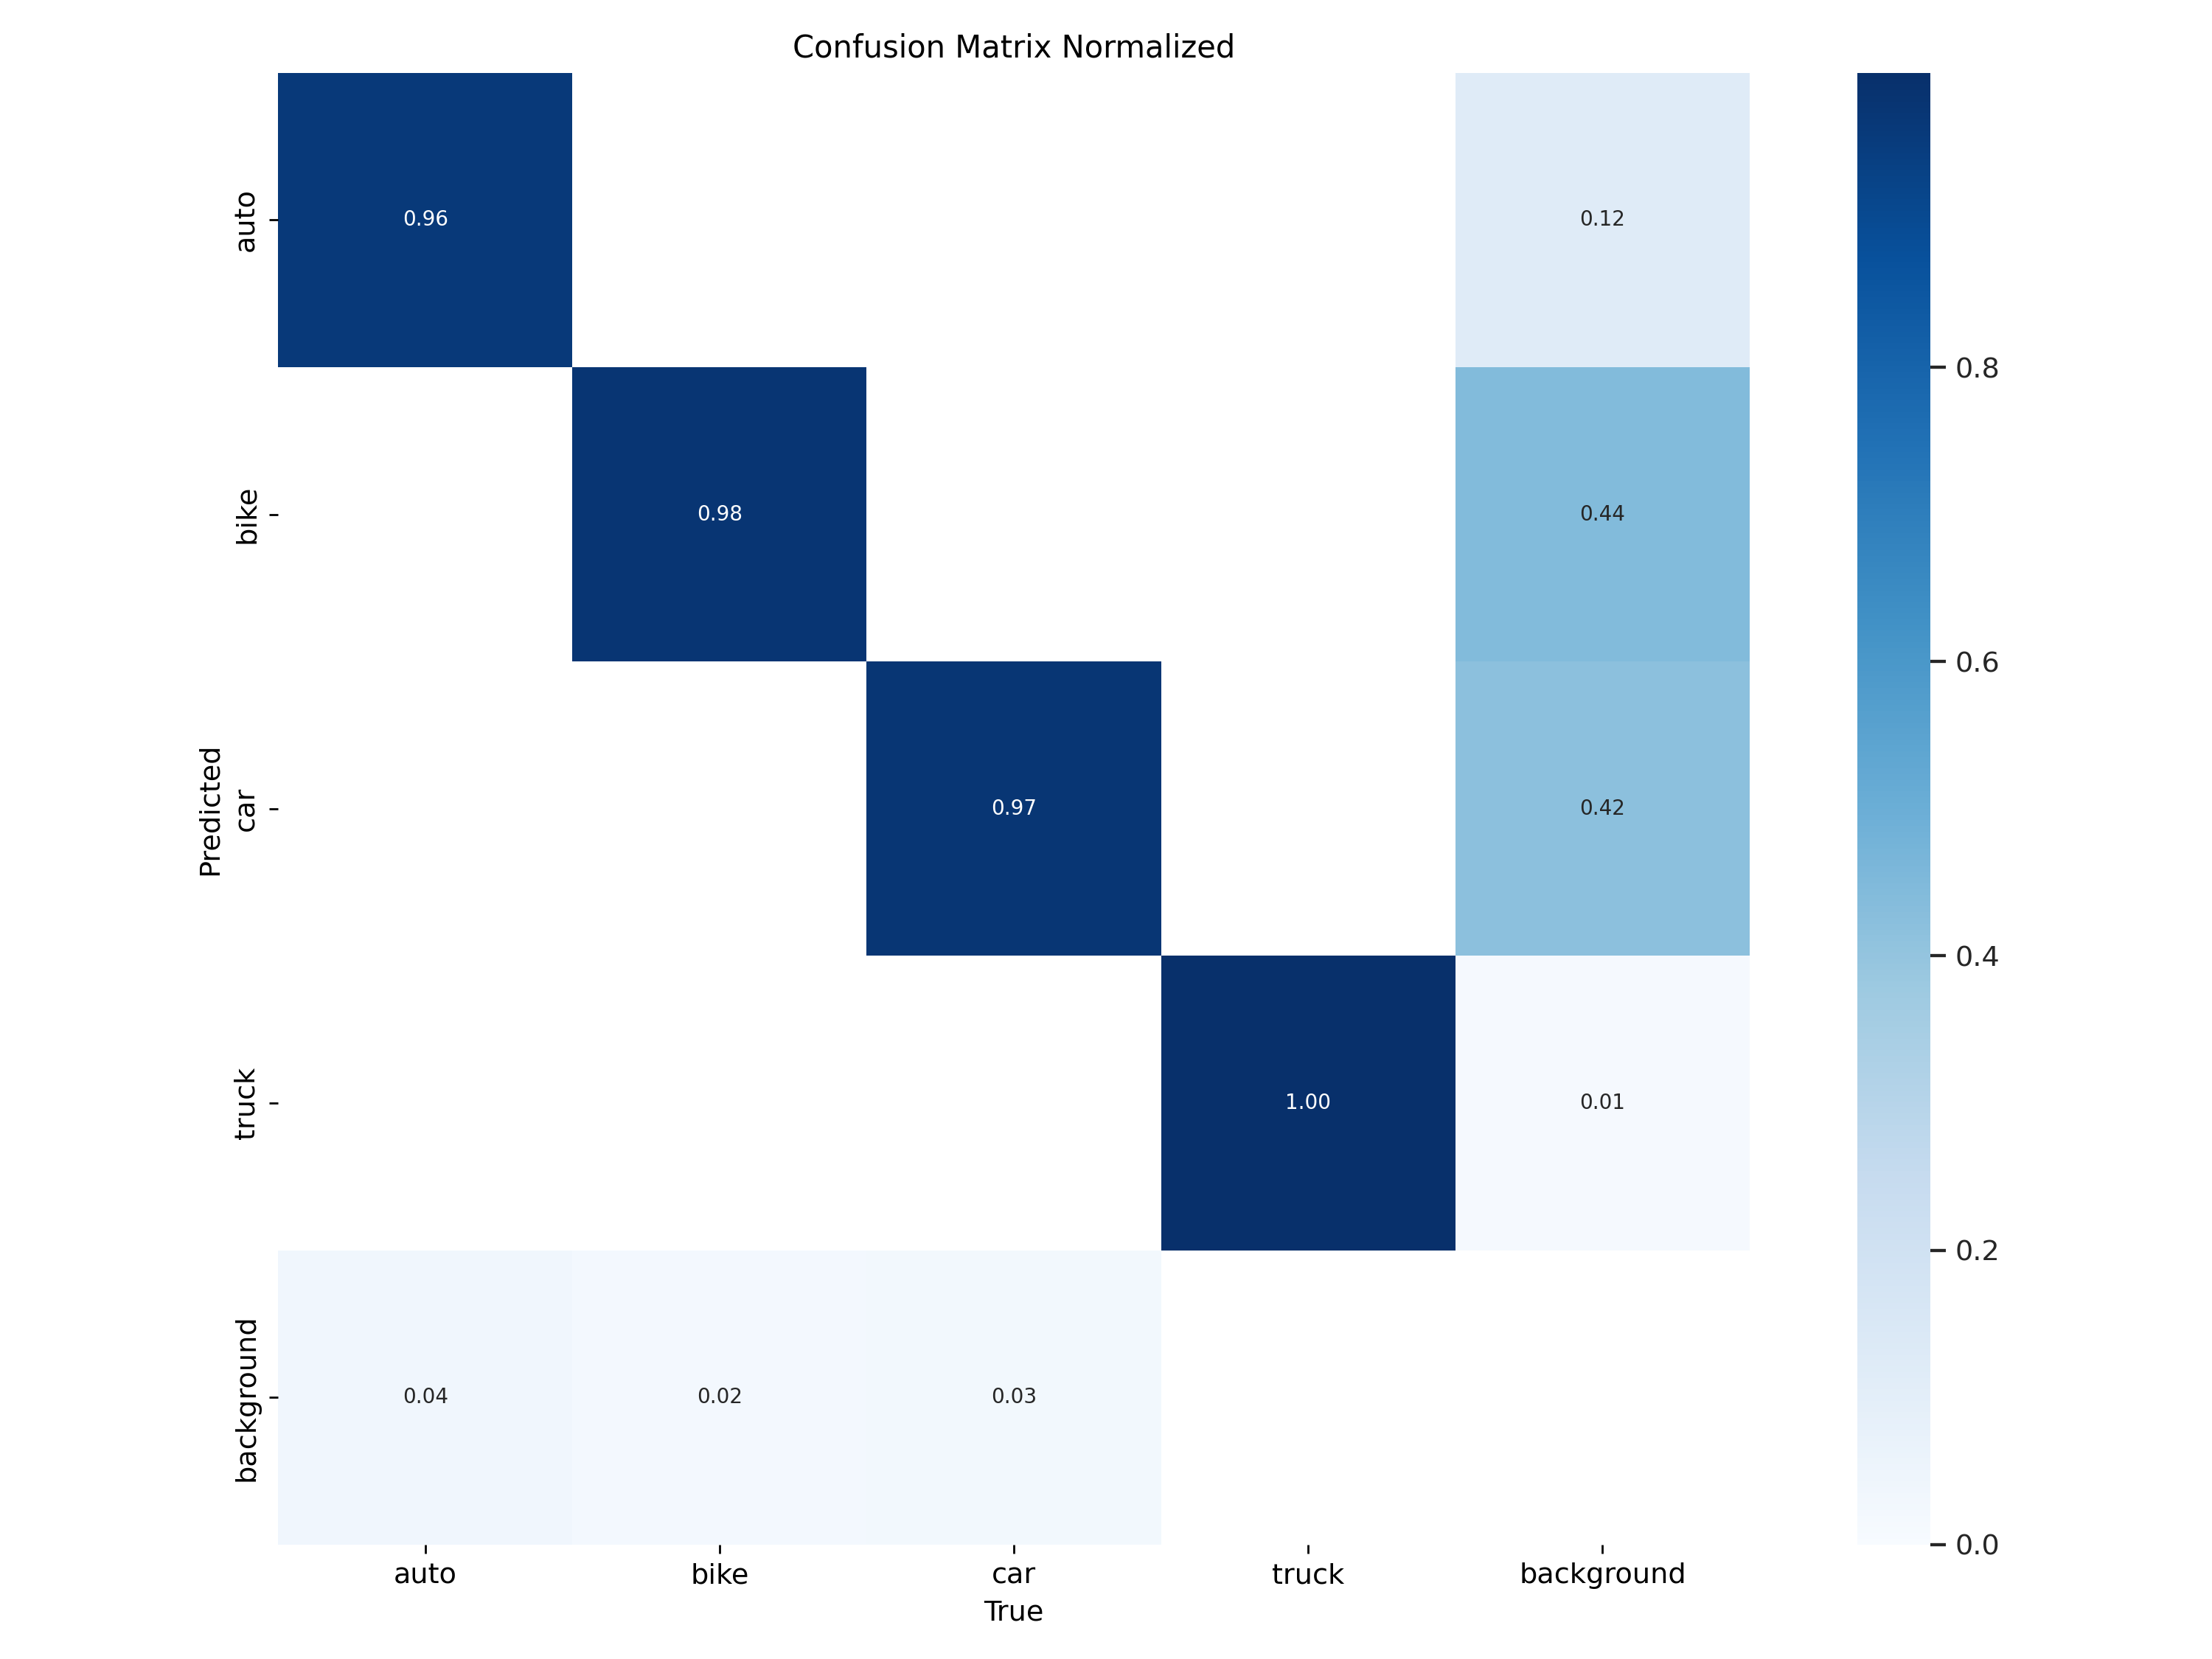

In [9]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png' , width=600)

/content


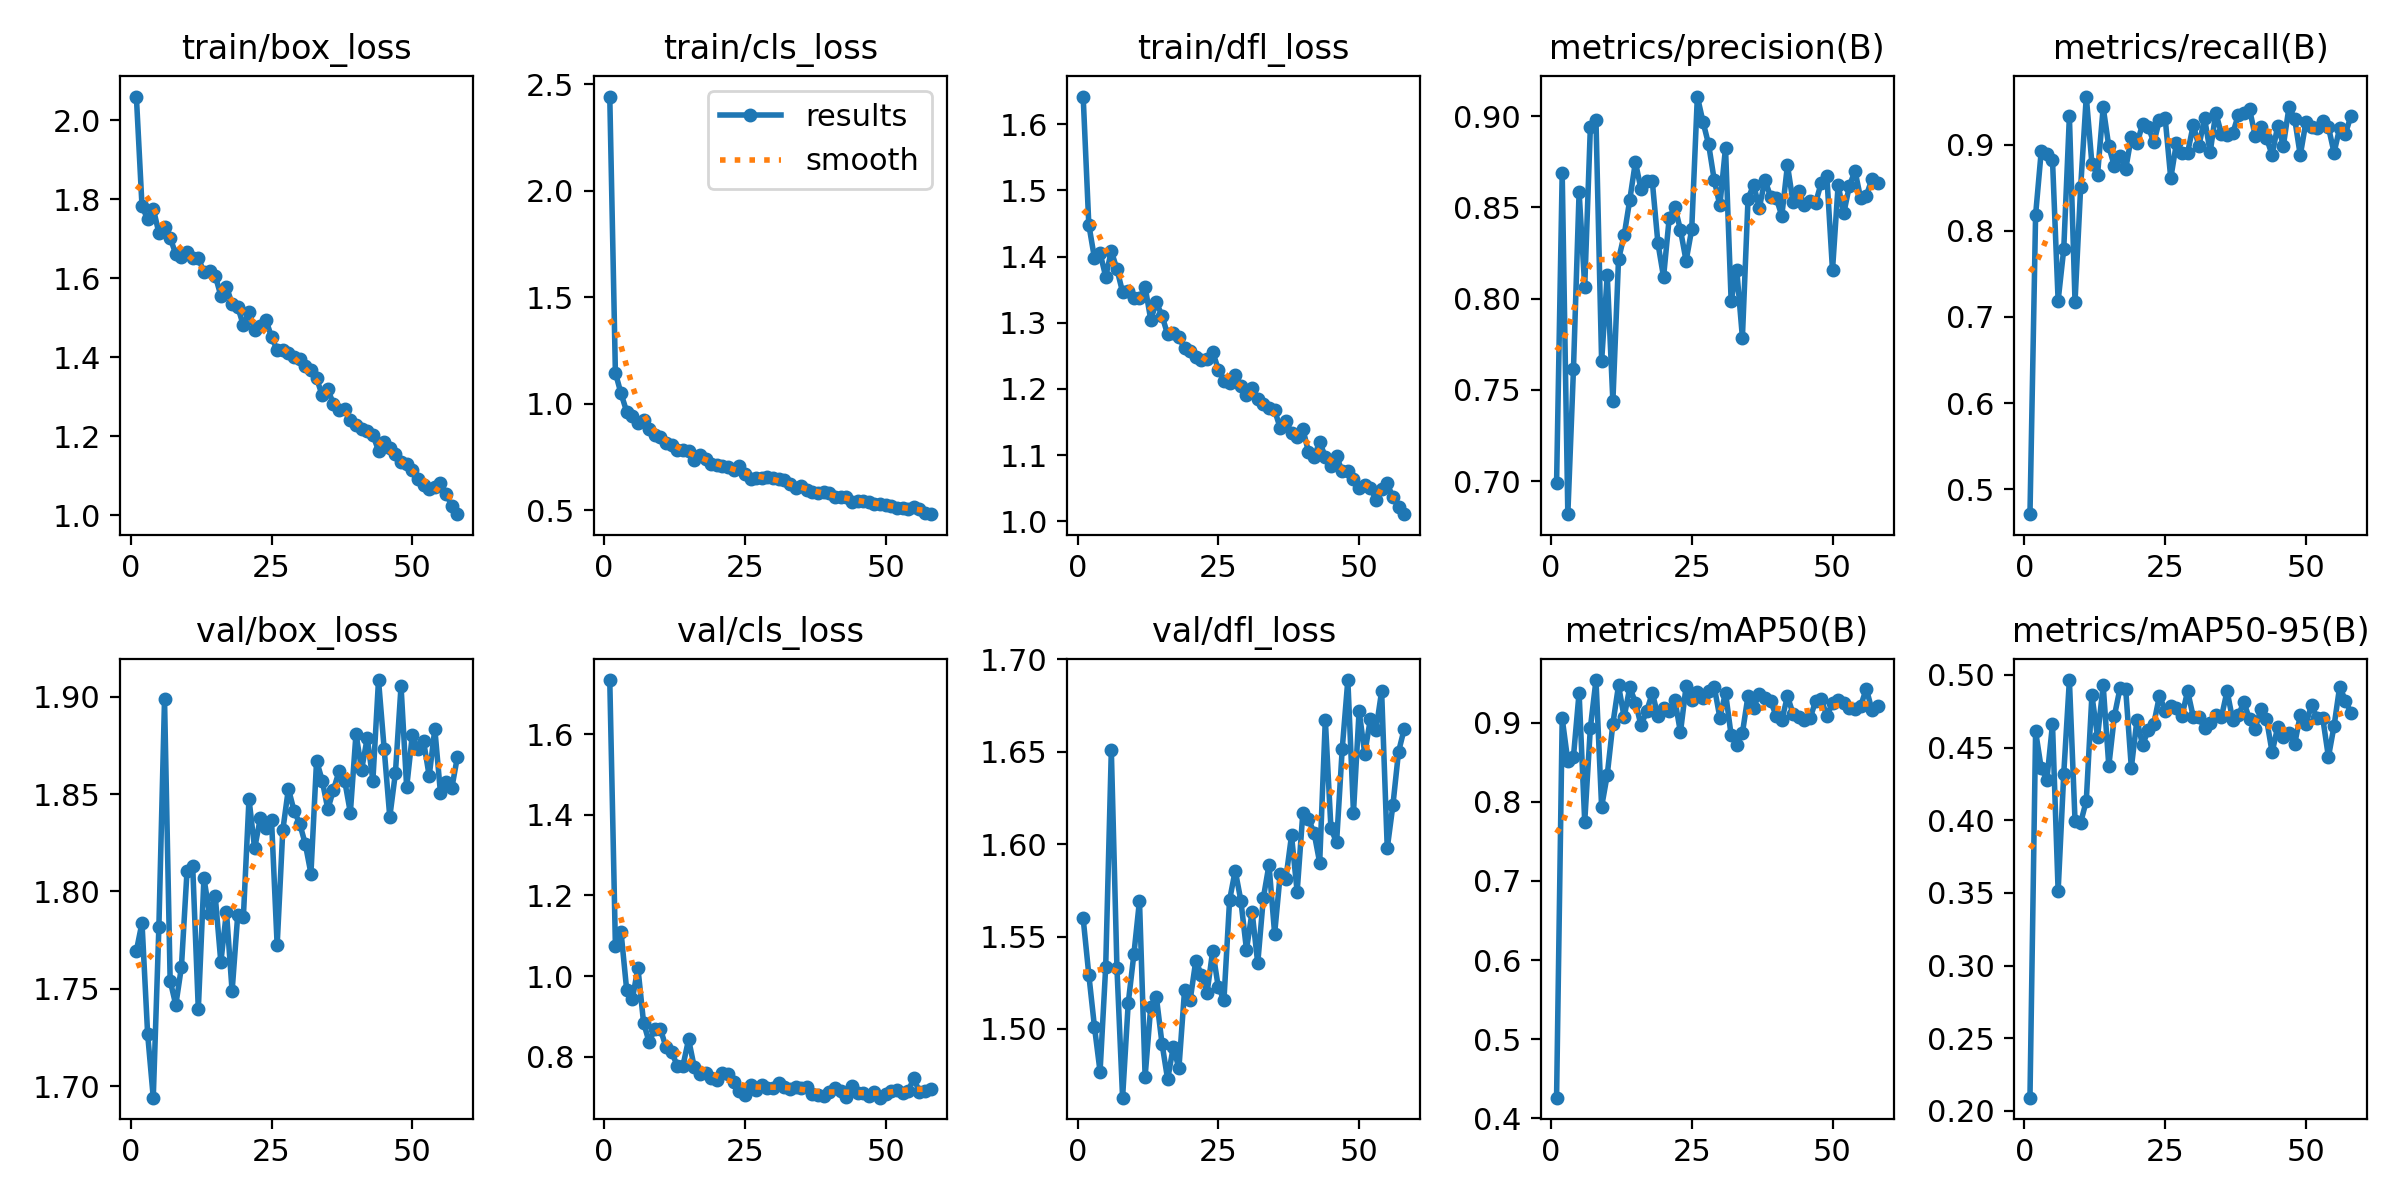

In [10]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


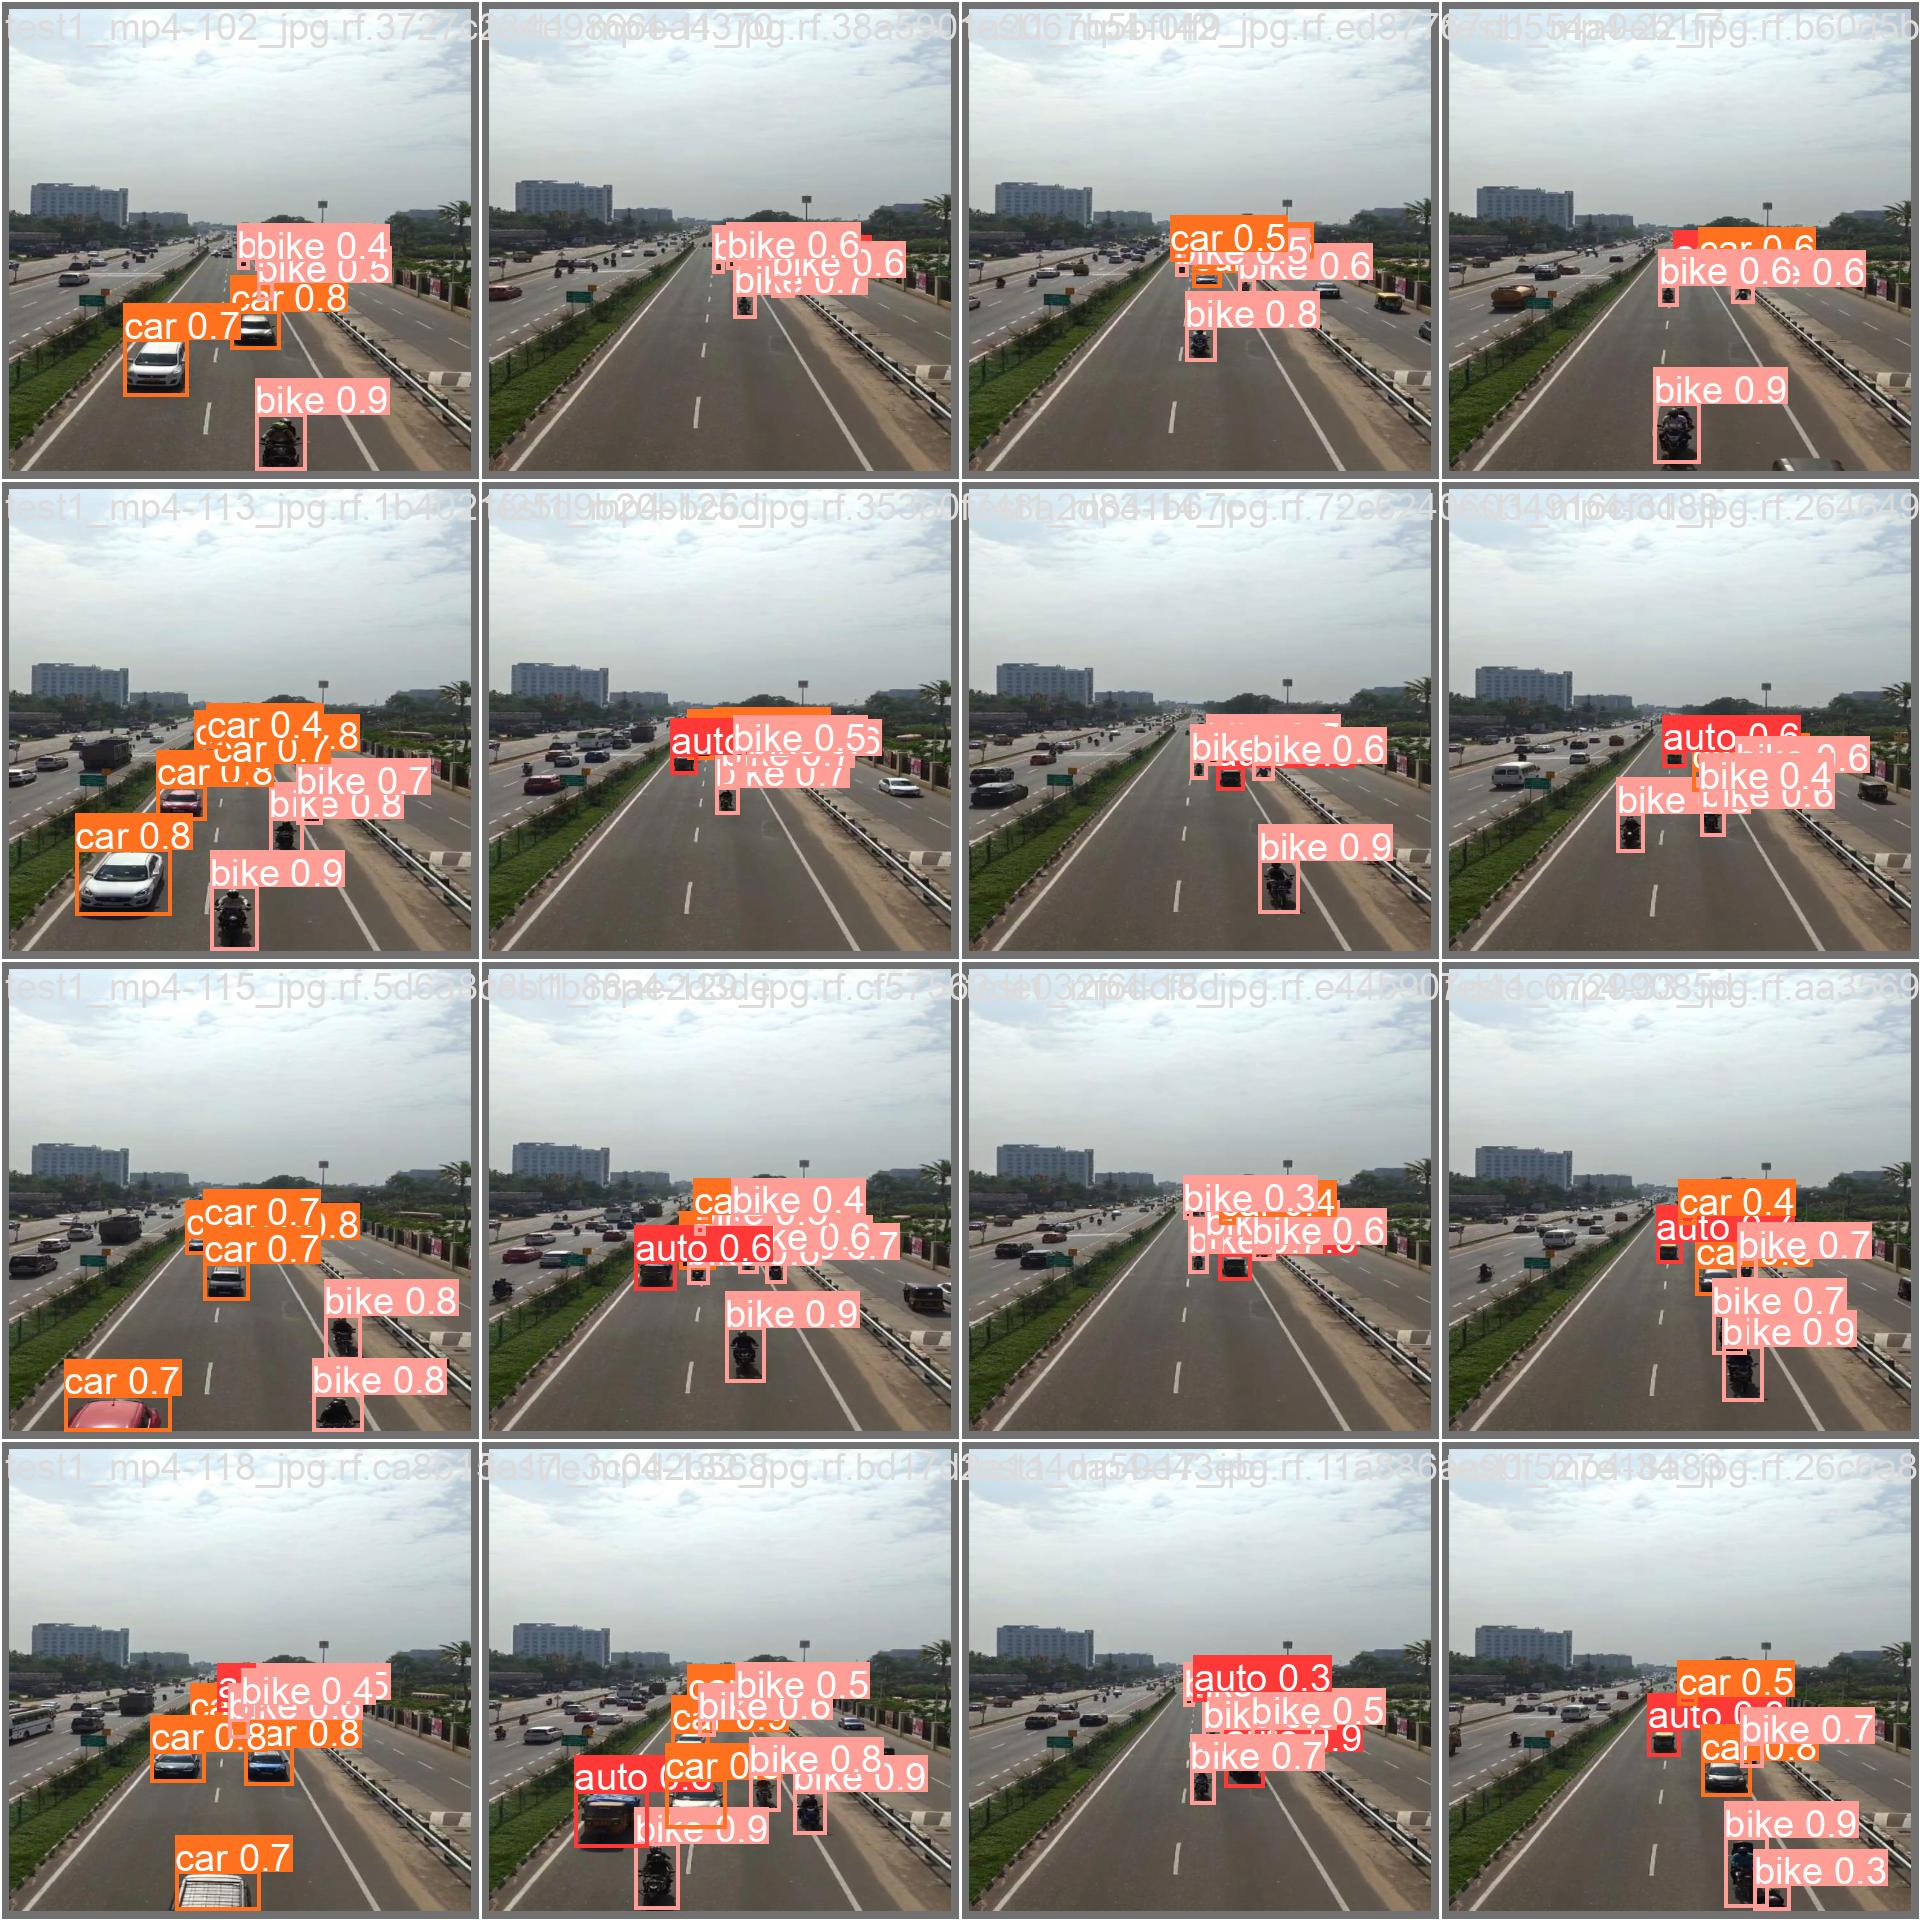

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [12]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/vehicle_detection_2-1/valid/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100% 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:06<00:00,  1.58s/it]
                   all         55        292      0.898      0.933      0.955      0.498
                  auto         55         27      0.811      0.963      0.946       0.52
                  bike         55        142      0.907      0.831      0.931      0.411
                   car         55        118      0.872      0.975      0.947       0.51
                 truck         55          5          1      0.962      0.995      0.551
Speed: 15.2ms preprocess, 56.8ms inference, 0.0ms loss, 13.6ms postprocess per image
Results saved to runs/detect/val
💡 L

## Inference with Custom Model

In [13]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/28 /content/vehicle_detection_2-1/test/images/test1_mp4-10_jpg.rf.9788b98b22d4b46d31bce54191e8f63d.jpg: 800x800 1 auto, 5 bikes, 22.5ms
image 2/28 /content/vehicle_detection_2-1/test/images/test1_mp4-112_jpg.rf.56bbe9a59628b3fb527475305df11dd6.jpg: 800x800 3 bikes, 6 cars, 22.6ms
image 3/28 /content/vehicle_detection_2-1/test/images/test1_mp4-117_jpg.rf.4c51a57c993c097a0460875245785402.jpg: 800x800 1 auto, 4 bikes, 4 cars, 22.6ms
image 4/28 /content/vehicle_detection_2-1/test/images/test1_mp4-122_jpg.rf.a89168da4084df79015b6c4b8b4f8c13.jpg: 800x800 1 auto, 6 bikes, 3 cars, 22.6ms
image 5/28 /content/vehicle_detection_2-1/test/images/test1_mp4-123_jpg.rf.50a454f91d5f20759fe3af7f342a2f3f.jpg: 800x800 1 auto, 4 bikes, 3 cars, 22.6ms
image 6/28 /content/vehicle_det

**NOTE:** Let's take a look at few results.

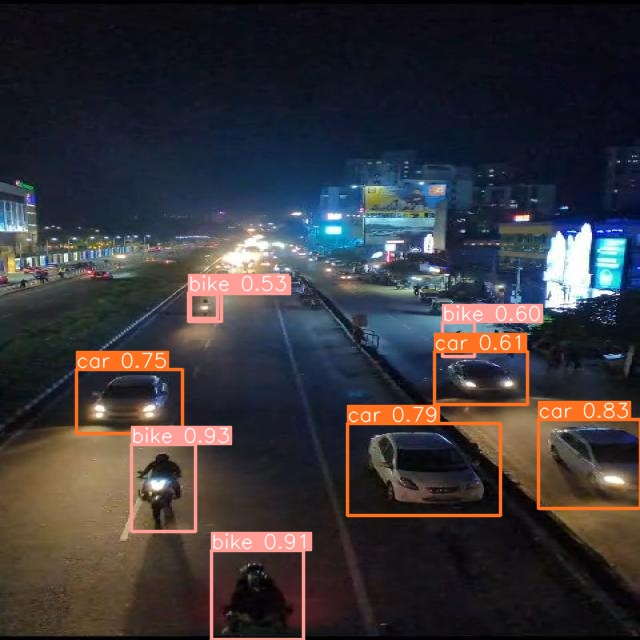

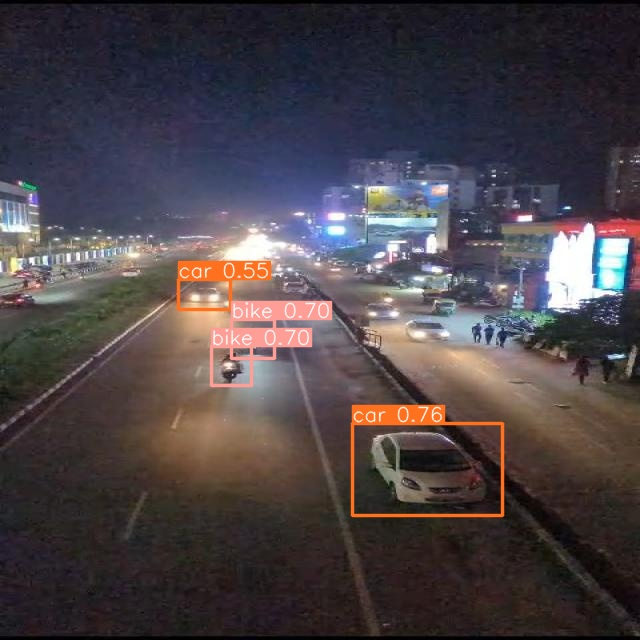

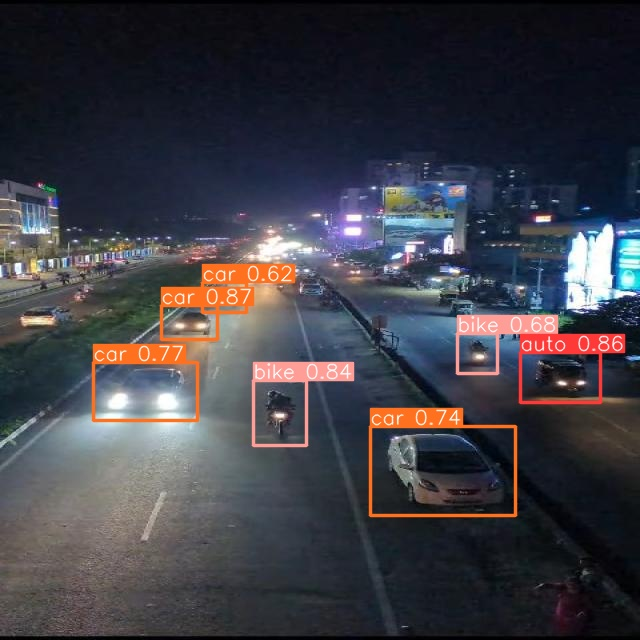

In [21]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [23]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/istockphoto-1400616052-640_adpp_is.mp4

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs

video 1/1 (1/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 106.4ms
video 1/1 (2/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.7ms
video 1/1 (3/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.6ms
video 1/1 (4/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.6ms
video 1/1 (5/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.6ms
video 1/1 (6/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.6ms
video 1/1 (7/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.5ms
video 1/1 (8/479) /content/istockphoto-1400616052-640_adpp_is.mp4: 480x800 (no detections), 15.5ms
video 1/1 (9/479) /content/istockphot